### CONTENTS
#### 1 Importing Libraries
#### 2 Importing Data 
#### 3 Data wrangling
#### 4 Random Forest Analysis
#### 5 Feature Importance Analysis


# 1 Importing Libraries

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.metrics import accuracy_score


# 2 Importing Data

In [115]:
path = r'C:\Users\elena\Documents\06.2025 climatewins machine learning'

In [117]:
# Upload cleaned data

In [119]:
climate = pd.read_csv(os.path.join(path, '02 Data', 'Original data', 'Dataset-weather-prediction-dataset-processed.csv'), index_col = False)

In [120]:
climate.head()

DATE  MONTH  BASEL_cloud_cover  BASEL_wind_speed  BASEL_humidity  \
0  19600101      1                  7               2.1            0.85   
1  19600102      1                  6               2.1            0.84   
2  19600103      1                  8               2.1            0.90   
3  19600104      1                  3               2.1            0.92   
4  19600105      1                  6               2.1            0.95   

   BASEL_pressure  BASEL_global_radiation  BASEL_precipitation  \
0           1.018                    0.32                 0.09   
1           1.018                    0.36                 1.05   
2           1.018                    0.18                 0.30   
3           1.018                    0.58                 0.00   
4           1.018                    0.65                 0.14   

   BASEL_snow_depth  BASEL_sunshine  ...  VALENTIA_cloud_cover  \
0                 0             0.7  ...                     5   
1                 0             1.1  ...                     7   
2                 0             0.0  ...                     7   
3                 0             4.1  ...                     7   
4                 0             5.4  ...                     3   

   VALENTIA_humidity  VALENTIA_pressure  VALENTIA_global_radiation  \
0               0.88             1.0003                       0.45   
1               0.91             1.0007                       0.25   
2               0.91             1.0096                       0.17   
3               0.86             1.0184                       0.13   
4               0.80             1.0328                       0.46   

   VALENTIA_precipitation  VALENTIA_snow_depth  VALENTIA_sunshine  \
0                    0.34                    0                4.7   
1                    0.84                    0                0.7   
2                    0.08                    0                0.1   
3                    0.98                    0                0.0   
4                    0.00                    0                5.7   

   VALENTIA_temp_mean  VALENTIA_temp_min  VALENTIA_temp_max  
0                 8.5                6.0               10.9  
1                 8.9                5.6               12.1  
2                10.5                8.1               12.9  
3                 7.4                7.3               10.6  
4                 5.7                3.0                8.4  

[5 rows x 170 columns]

In [123]:
# Import the pleasant weather data.
pleasantweather = pd.read_csv(os.path.join(path, '02 Data', 'Original Data','Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))

# 3 Data Wrangling

In [126]:
climate.columns

Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_wind_speed',
       'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation',
       'BASEL_precipitation', 'BASEL_snow_depth', 'BASEL_sunshine',
       ...
       'VALENTIA_cloud_cover', 'VALENTIA_humidity', 'VALENTIA_pressure',
       'VALENTIA_global_radiation', 'VALENTIA_precipitation',
       'VALENTIA_snow_depth', 'VALENTIA_sunshine', 'VALENTIA_temp_mean',
       'VALENTIA_temp_min', 'VALENTIA_temp_max'],
      dtype='object', length=170)

In [128]:
# Drop weather stations for which pleasant/unpleasant classification is not available

In [130]:
cols_to_drop = [col for col in climate.columns if any(city in col for city in ['GDANSK', 'ROMA', 'TOURS'])]


In [132]:
climate = climate.drop(columns=cols_to_drop)

In [134]:
climate.shape

(22950, 149)

In [136]:
# Extract the different observation types

observation_types = ['cloud_cover', 'wind_speed', 'humidity', 'pressure',
                     'global_radiation', 'precipitation', 'snow_depth', 
                     'sunshine', 'temp_mean', 'temp_min', 'temp_max']

In [138]:
# Create a dictionary to store the count of stations for each observation type
station_counts = {}

for obs in observation_types:
    # Select columns related to the current observation type
    columns = [col for col in climate.columns if col.endswith(obs)]
    
    # Count the number of stations (i.e., the number of columns) for the current observation type
    station_counts[obs] = len(columns)

# Print the count of stations for each observation type
print("Number of stations covered by each observation type:")
for obs, count in station_counts.items():
    print(f"{obs}: {count} stations")

Number of stations covered by each observation type:
cloud_cover: 14 stations
wind_speed: 9 stations
humidity: 14 stations
pressure: 14 stations
global_radiation: 15 stations
precipitation: 15 stations
snow_depth: 6 stations
sunshine: 15 stations
temp_mean: 15 stations
temp_min: 15 stations
temp_max: 15 stations


Wind speed and snow depth data is missing for a number of stations, so will remove these factors.

In [141]:
# Get a list of columns containing 'wind_speed' or 'snow_depth'
cols_to_drop = [col for col in climate.columns if '_wind_speed' in col or '_snow_depth' in col]

# Drop the columns
climate = climate.drop(cols_to_drop, axis=1)

In [143]:
climate.shape

(22950, 134)

Data from one location is missing for the following observation types: cloud cover, humidity and pressure.
Need to find out which stations are missing a column

In [146]:
stationParameters = {}
allParameters = set()

pairs = [p.split('_', 1) for p in climate.columns]

for pair in pairs:
    if len(pair) < 2: continue
    if pair[0] not in stationParameters:
        stationParameters[pair[0]] = set()
    stationParameters[pair[0]].add(pair[1])
    allParameters.add(pair[1])

stationParameters.keys()

dict_keys(['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA'])

In [148]:
for station, parameters in stationParameters.items():
    if allParameters - parameters:
        print(station, "Missing:",  allParameters - parameters)

KASSEL Missing: {'cloud_cover'}
MUNCHENB Missing: {'pressure'}
STOCKHOLM Missing: {'humidity'}


In [150]:
# Create missing Kessel cloud cover and insert into the appropriate place.

In [152]:
# Step 1: Copy the column and assign to a new one
climate['KASSEL_cloud_cover'] = climate['LJUBLJANA_cloud_cover'].copy()

In [154]:
# Step 2: Get list of column names
cols = list(climate.columns)

# Step 3: Find index of the column *after which* to insert the new one
insert_after = 'HEATHROW_temp_max'
insert_at = cols.index(insert_after) + 1

# Step 4: Remove 'KASSEL_cloud_cover' from its current position (end of list)
cols.remove('KASSEL_cloud_cover')

# Step 5: Insert it at the desired position
cols.insert(insert_at, 'KASSEL_cloud_cover')

# Step 6: Reorder the DataFrame
climate = climate[cols]

In [156]:

# Create missing 'MUNCHENB_pressure' and insert after 'MUNCHENB_humidity'

In [158]:
# Step 1: Copy the column and assign to a new one
climate['MUNCHENB_pressure'] = climate['SONNBLICK_pressure'].copy()

In [160]:
# Step 2: Get list of column names
cols = list(climate.columns)

# Step 3: Find index of the column *after which* to insert the new one
insert_after = 'MUNCHENB_humidity'
insert_at = cols.index(insert_after) + 1

# Step 4: Remove 'MUNCHENB_pressure' from its current position (end of list)
cols.remove('MUNCHENB_pressure')

# Step 5: Insert it at the desired position
cols.insert(insert_at, 'MUNCHENB_pressure')

# Step 6: Reorder the DataFrame
climate = climate[cols]

In [162]:

# Create missing 'STOCKHOLM_humidity' and insert after STOCKHOLM_cloud_cover'

In [164]:
# Step 1: Copy the column and assign to a new one
climate['STOCKHOLM_humidity'] = climate['OSLO_humidity'].copy()

In [166]:
# Step 2: Get list of column names
cols = list(climate.columns)

# Step 3: Find index of the column *after which* to insert the new one
insert_after = 'STOCKHOLM_cloud_cover'
insert_at = cols.index(insert_after) + 1

# Step 4: Remove 'MUNCHENB_pressure' from its current position (end of list)
cols.remove('STOCKHOLM_humidity')

# Step 5: Insert it at the desired position
cols.insert(insert_at, 'STOCKHOLM_humidity')

# Step 6: Reorder the DataFrame
climate = climate[cols]

In [168]:
list(climate.columns)

['DATE',
 'MONTH',
 'BASEL_cloud_cover',
 'BASEL_humidity',
 'BASEL_pressure',
 'BASEL_global_radiation',
 'BASEL_precipitation',
 'BASEL_sunshine',
 'BASEL_temp_mean',
 'BASEL_temp_min',
 'BASEL_temp_max',
 'BELGRADE_cloud_cover',
 'BELGRADE_humidity',
 'BELGRADE_pressure',
 'BELGRADE_global_radiation',
 'BELGRADE_precipitation',
 'BELGRADE_sunshine',
 'BELGRADE_temp_mean',
 'BELGRADE_temp_min',
 'BELGRADE_temp_max',
 'BUDAPEST_cloud_cover',
 'BUDAPEST_humidity',
 'BUDAPEST_pressure',
 'BUDAPEST_global_radiation',
 'BUDAPEST_precipitation',
 'BUDAPEST_sunshine',
 'BUDAPEST_temp_mean',
 'BUDAPEST_temp_min',
 'BUDAPEST_temp_max',
 'DEBILT_cloud_cover',
 'DEBILT_humidity',
 'DEBILT_pressure',
 'DEBILT_global_radiation',
 'DEBILT_precipitation',
 'DEBILT_sunshine',
 'DEBILT_temp_mean',
 'DEBILT_temp_min',
 'DEBILT_temp_max',
 'DUSSELDORF_cloud_cover',
 'DUSSELDORF_humidity',
 'DUSSELDORF_pressure',
 'DUSSELDORF_global_radiation',
 'DUSSELDORF_precipitation',
 'DUSSELDORF_sunshine',
 'DUSS

In [170]:
climate.shape

(22950, 137)

In [172]:
pleasantweather.shape

(22950, 16)

In [174]:
# Select data for one decade, so the model doesn't run too long. Use the latest decade since the most recent data is likely to be the most accurate.

In [176]:
climate2010s = climate[
    (climate['DATE'].astype(str).str[:4] >= '2010') &
    (climate['DATE'].astype(str).str[:4] <= '2019')
]


In [178]:
climate2010s.head()

DATE  MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
18263  20100101      1                  8            0.93          0.9965   
18264  20100102      1                  3            0.74          1.0193   
18265  20100103      1                  3            0.75          1.0226   
18266  20100104      1                  5            0.83          1.0169   
18267  20100105      1                  7            0.78          1.0073   

       BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
18263                    0.18                 0.56             0.0   
18264                    0.58                 0.00             5.2   
18265                    0.61                 0.00             6.3   
18266                    0.48                 0.00             3.7   
18267                    0.53                 0.04             4.4   

       BASEL_temp_mean  BASEL_temp_min  ...  STOCKHOLM_temp_max  \
18263              2.9            -0.2  ...                -7.0   
18264             -1.5            -4.2  ...                -7.1   
18265             -3.2            -6.0  ...                -7.1   
18266             -4.9            -8.3  ...                -3.6   
18267             -4.0            -7.1  ...                -5.5   

       VALENTIA_cloud_cover  VALENTIA_humidity  VALENTIA_pressure  \
18263                     1               0.80             1.0121   
18264                     1               0.82             1.0196   
18265                     4               0.71             1.0196   
18266                     2               0.67             1.0219   
18267                     4               0.78             1.0117   

       VALENTIA_global_radiation  VALENTIA_precipitation  VALENTIA_sunshine  \
18263                       0.43                    0.00                6.0   
18264                       0.45                    0.00                6.0   
18265                       0.36                    0.41                1.6   
18266                       0.48                    0.51                6.5   
18267                       0.45                    0.09                4.7   

       VALENTIA_temp_mean  VALENTIA_temp_min  VALENTIA_temp_max  
18263                 1.7               -1.6                5.0  
18264                 0.8               -4.5                6.2  
18265                 0.5               -4.1                5.1  
18266                 3.7                1.3                3.8  
18267                 2.3               -0.7                5.4  

[5 rows x 137 columns]

In [180]:
# Select wheather classifications for 2020s decade

In [182]:
pleasantweather2010s = pleasantweather[
    (pleasantweather['DATE'].astype(str).str[:4] >= '2010') &
    (pleasantweather['DATE'].astype(str).str[:4] <= '2019')
]

In [184]:
# Creating X data for analyses

In [186]:
X = climate2010s.drop(columns=['DATE', 'MONTH'])

In [188]:
# Creating y data for analyses. Need data from one 1 weather station.

In [190]:
y = pleasantweather2010s.drop(columns=['DATE'])

In [192]:
y.head()

BASEL_pleasant_weather  BELGRADE_pleasant_weather  \
18263                       0                          0   
18264                       0                          0   
18265                       0                          0   
18266                       0                          0   
18267                       0                          0   

       BUDAPEST_pleasant_weather  DEBILT_pleasant_weather  \
18263                          0                        0   
18264                          0                        0   
18265                          0                        0   
18266                          0                        0   
18267                          0                        0   

       DUSSELDORF_pleasant_weather  HEATHROW_pleasant_weather  \
18263                            0                          0   
18264                            0                          0   
18265                            0                          0   
18266                            0                          0   
18267                            0                          0   

       KASSEL_pleasant_weather  LJUBLJANA_pleasant_weather  \
18263                        0                           0   
18264                        0                           0   
18265                        0                           0   
18266                        0                           0   
18267                        0                           0   

       MAASTRICHT_pleasant_weather  MADRID_pleasant_weather  \
18263                            0                        0   
18264                            0                        0   
18265                            0                        0   
18266                            0                        0   
18267                            0                        0   

       MUNCHENB_pleasant_weather  OSLO_pleasant_weather  \
18263                          0                      0   
18264                          0                      0   
18265                          0                      0   
18266                          0                      0   
18267                          0                      0   

       SONNBLICK_pleasant_weather  STOCKHOLM_pleasant_weather  \
18263                           0                           0   
18264                           0                           0   
18265                           0                           0   
18266                           0                           0   
18267                           0                           0   

       VALENTIA_pleasant_weather  
18263                          0  
18264                          0  
18265                          0  
18266                          0  
18267                          0

In [194]:
X.shape

(3652, 135)

In [196]:
y.shape

(3652, 15)

In [198]:
# Turn X and y from a df to NumPy arrays

X = np.array(X)
y = np.array(y)

Data is ready for modeling

# 4 Random Forest Analysis

In [202]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [204]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2739, 135) (2739, 15)
(913, 135) (913, 15)


In [206]:
# Wrap your classifier
multi_clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

In [208]:
# Fit on full multi-output y
multi_clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [209]:
# Predict
y_pred = multi_clf.predict(X_test)

In [212]:
# Use metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  0.8499452354874042


The accuracy is high. But as discussed in the previous tasks, accuracy is not the best measure. It is best to use average weighted F1 value. 

In [214]:
# Calculate weighted F1 score across all stations
f1 = f1_score(y_test, y_pred, average='weighted')  # May give warning for multilabel
print(f"Weighted F1 Score (All stations): {f1:.4f}")

Weighted F1 Score (All stations): 0.9740


C:\Users\elena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


High F1 score indicates the model is performing very well. 

In [225]:
# Step 1: Fit the model
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = MultiOutputClassifier(base_rf)
clf.fit(X_train, y_train)  # y_train must be shape (n_samples, 15)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [227]:
# Access the fitted RF model for the first station
rf_model = clf.estimators_[0]

In [229]:
# Access the 6th decision tree in that forest
tree_to_plot = rf_model.estimators_[5]

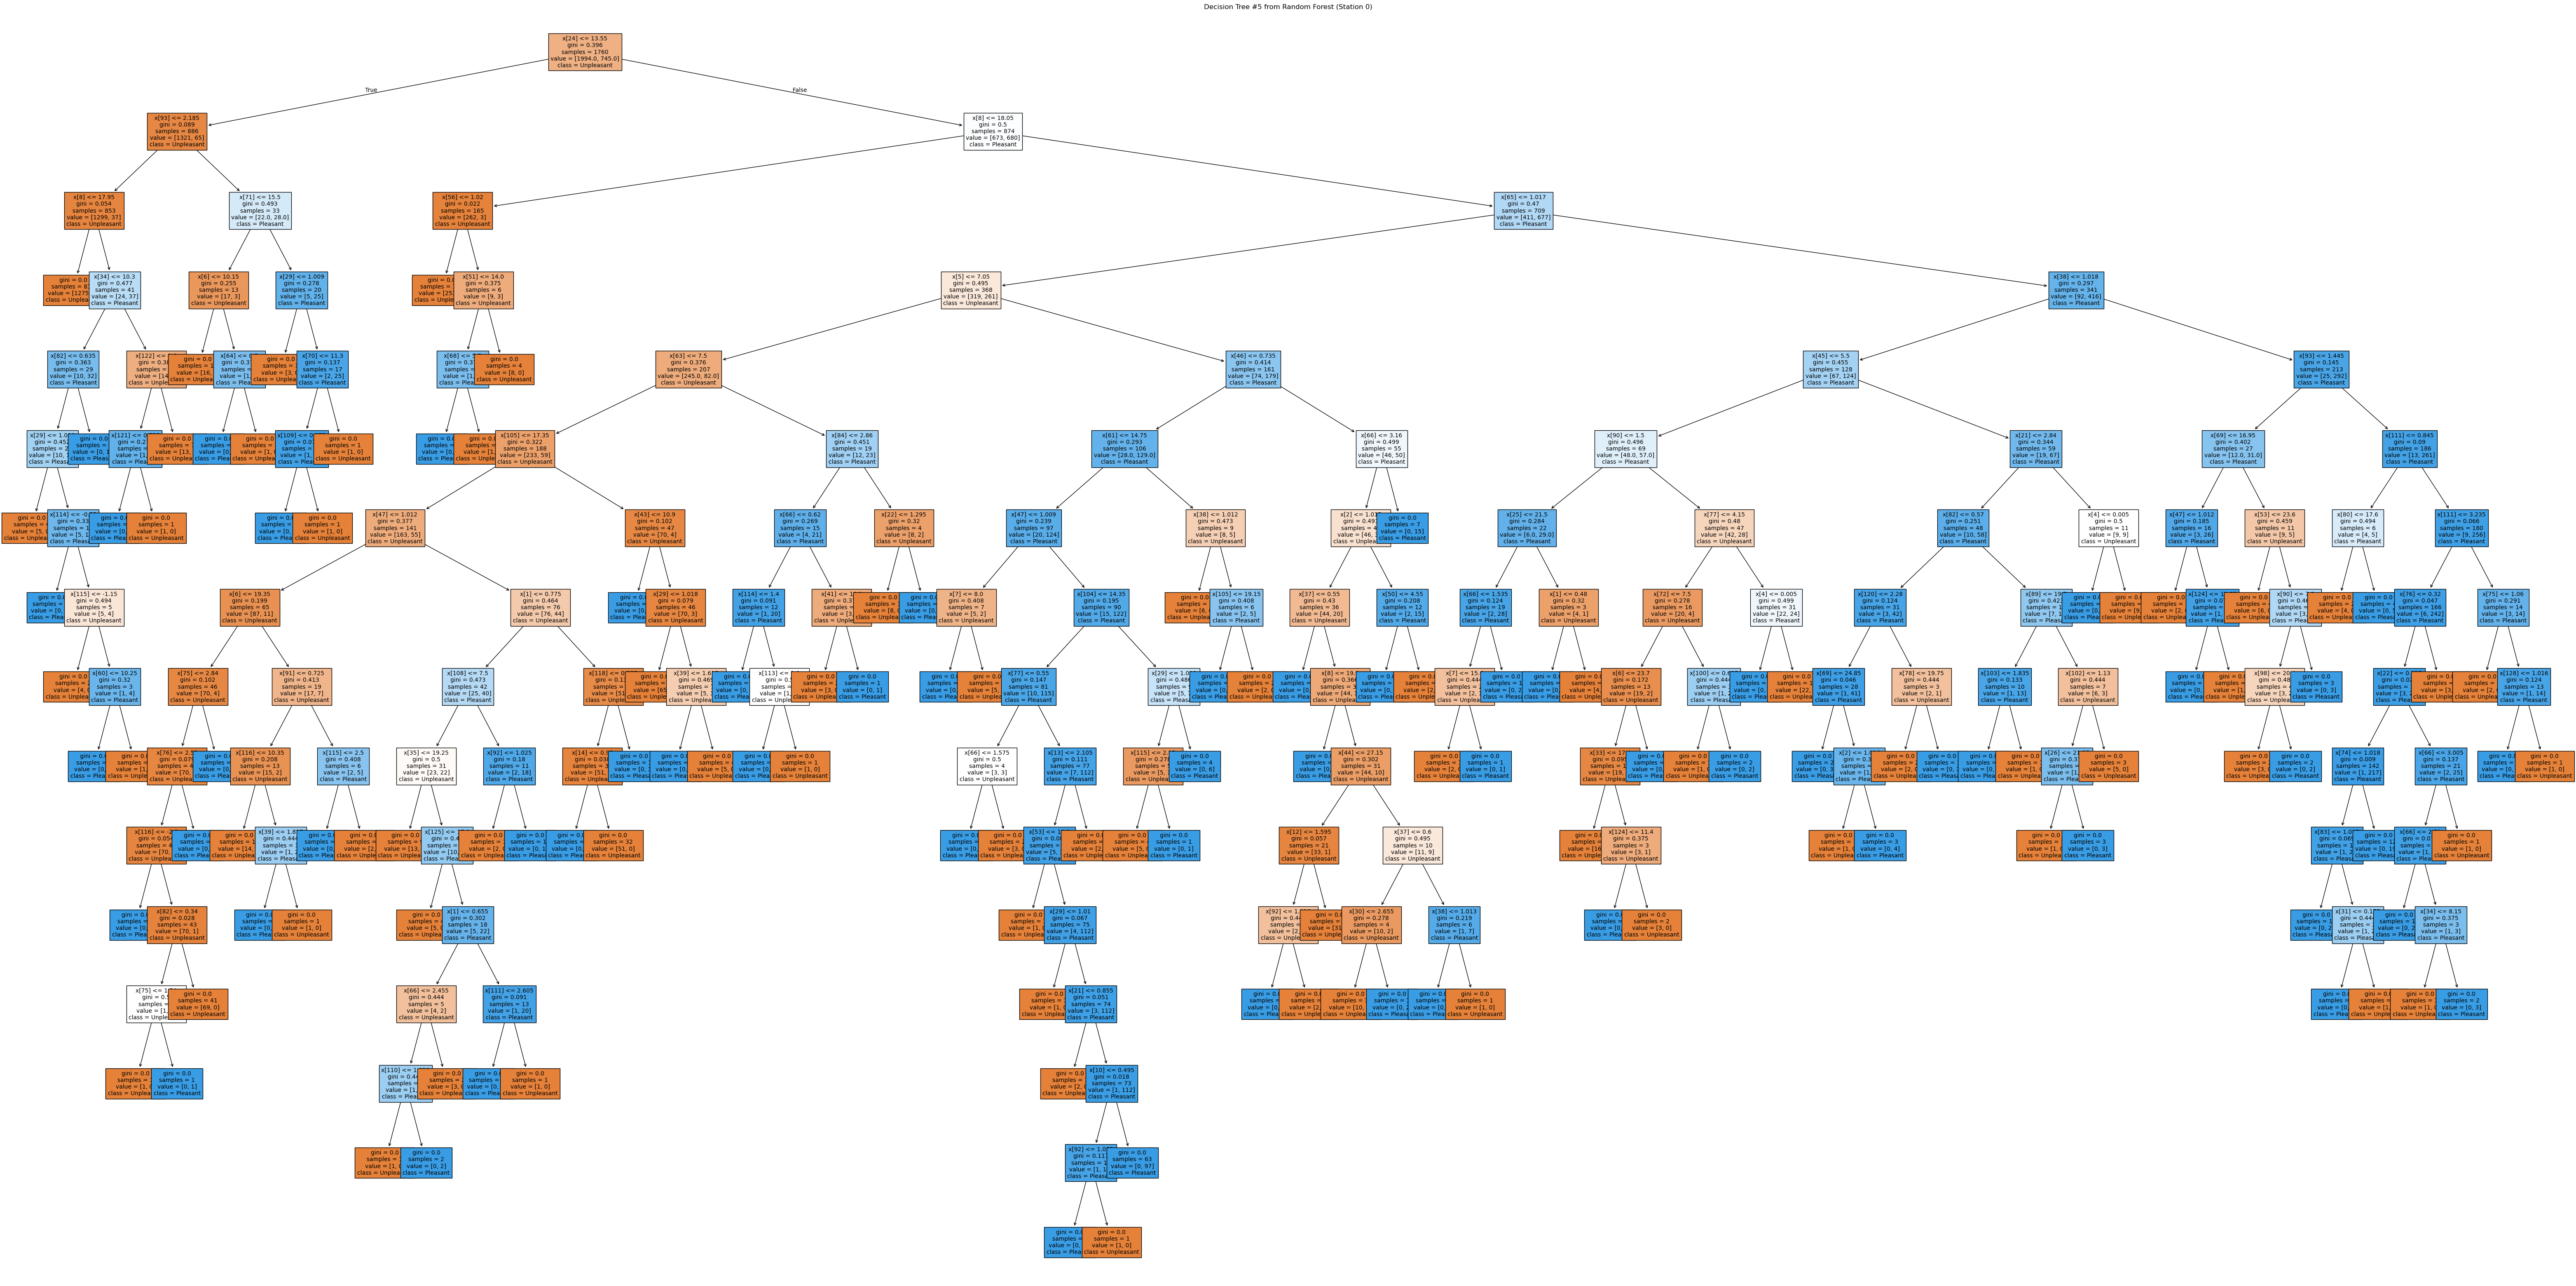

In [231]:
# Plot it
fig1 = plt.figure(figsize=(80, 40))
plot_tree(tree_to_plot, class_names=['Unpleasant', 'Pleasant'], filled=True, fontsize=10)
plt.title("Decision Tree #5 from Random Forest (Station 0)")
plt.show()

In [233]:
# Access the fitted RF model for the first station
rf_model = clf.estimators_[7]

In [235]:
# Access the 6th decision tree in that forest
tree_to_plot = rf_model.estimators_[5]

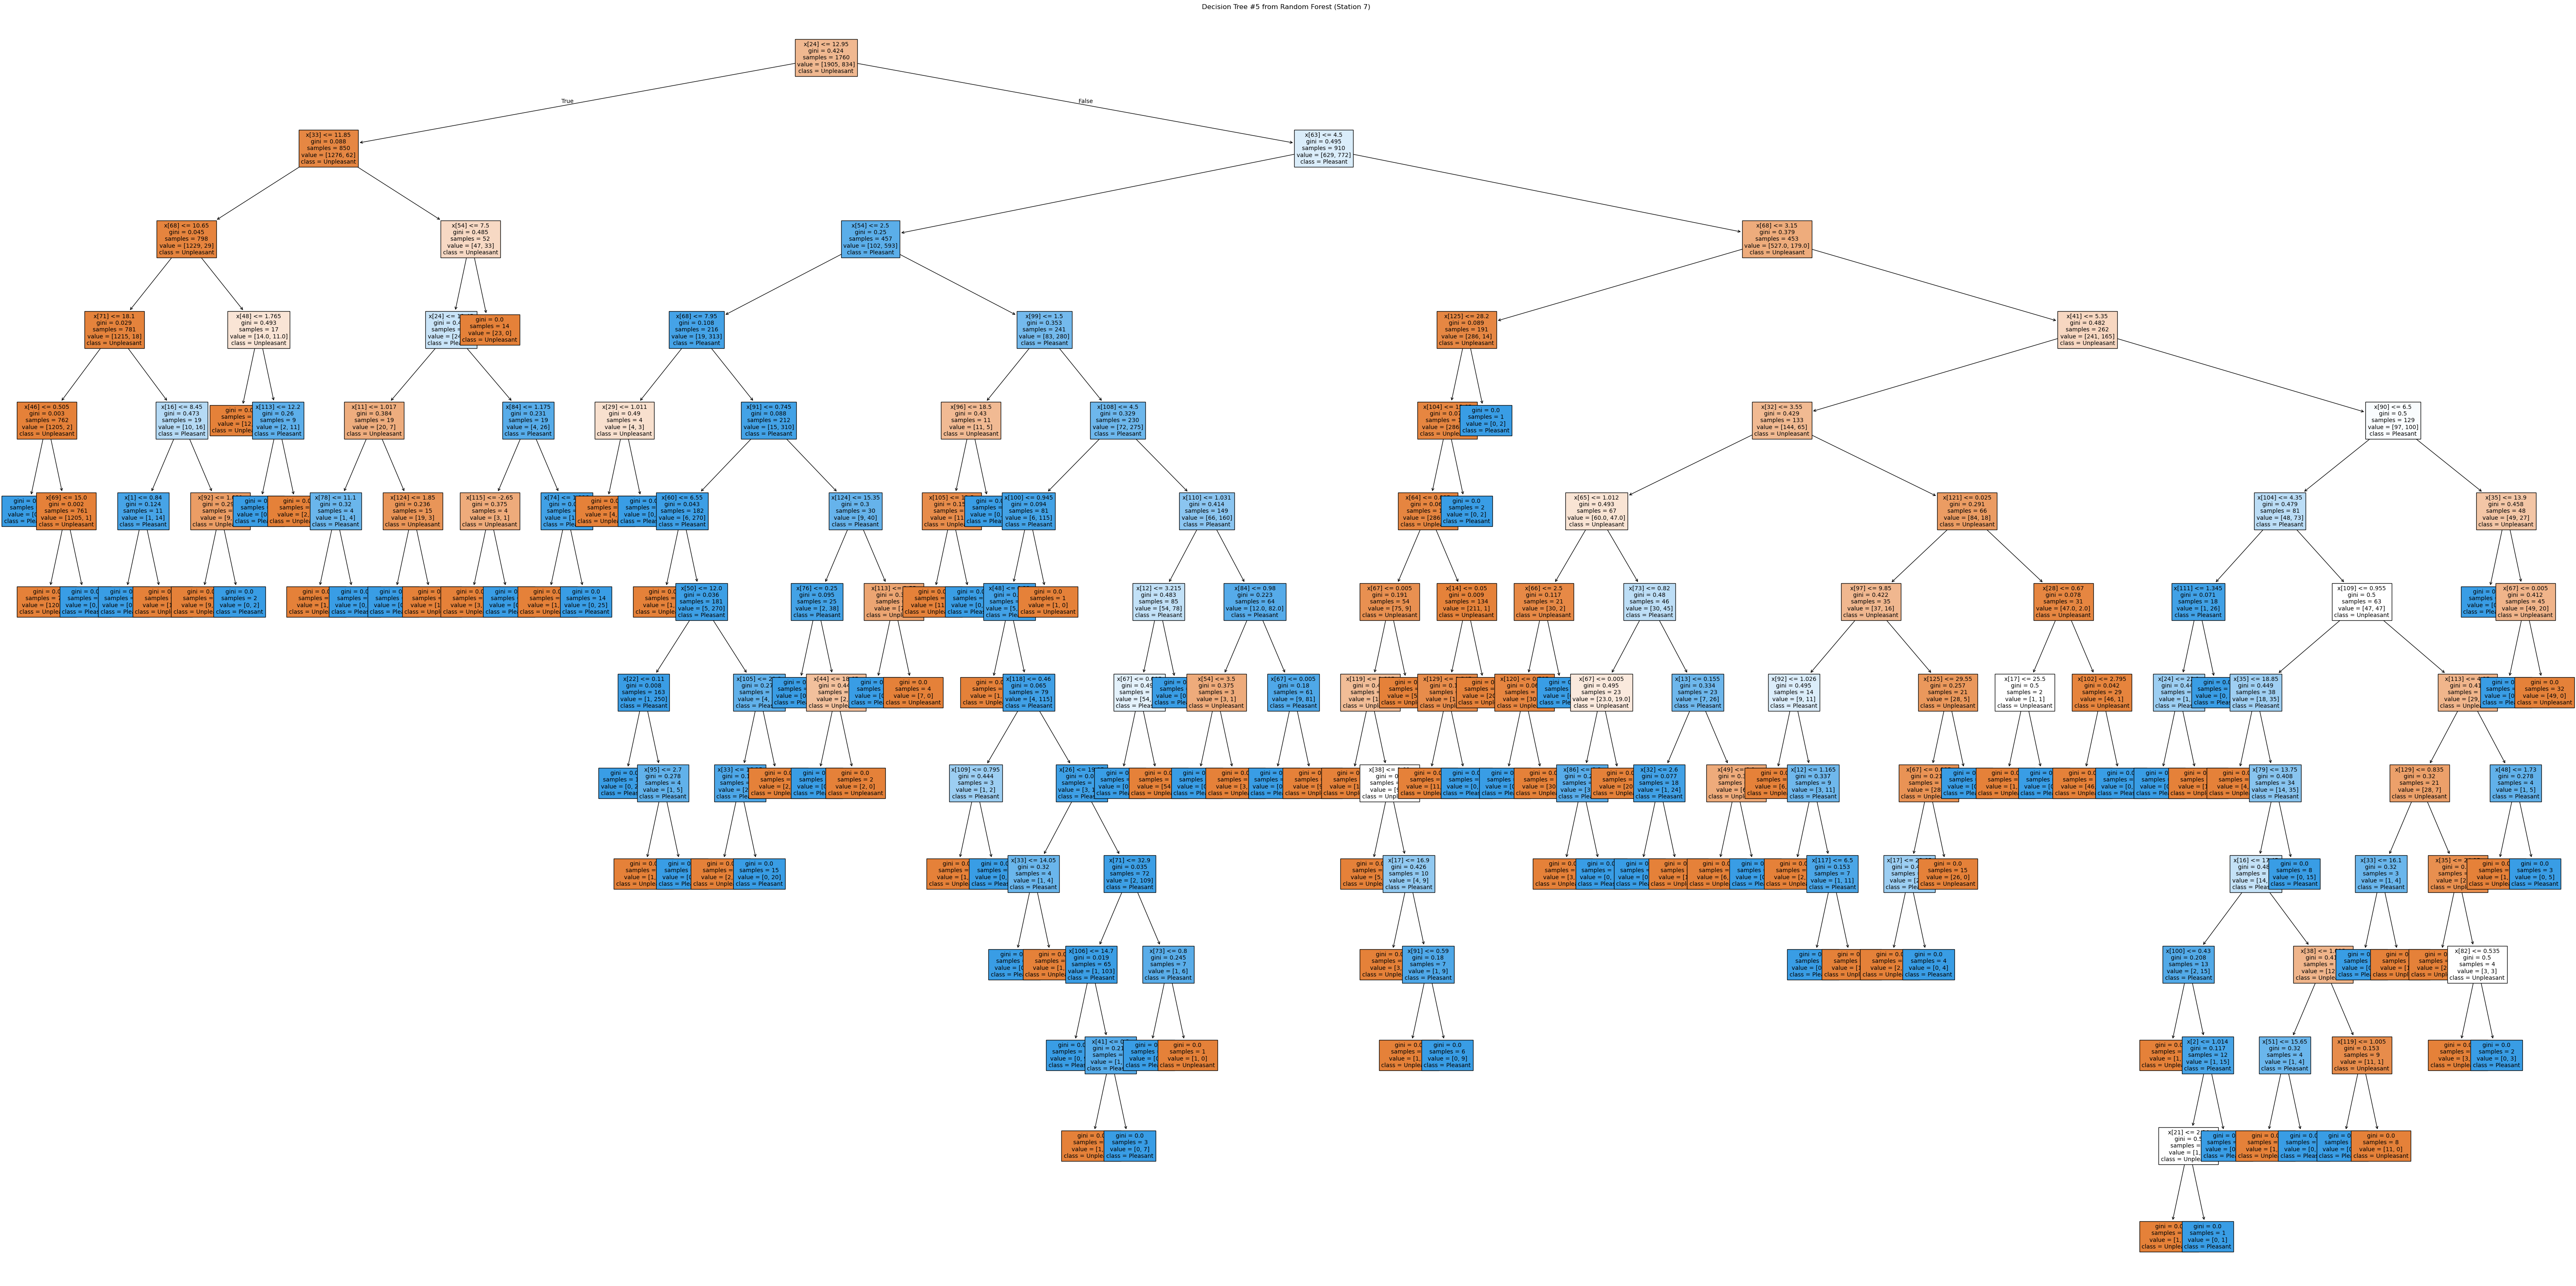

In [237]:
# Plot it
fig2 = plt.figure(figsize=(80, 40))
plot_tree(tree_to_plot, class_names=['Unpleasant', 'Pleasant'], filled=True, fontsize=10)
plt.title("Decision Tree #5 from Random Forest (Station 7)")
plt.show()

In [239]:
fig1.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'tree1.png'))

In [241]:
fig2.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'tree2.png'))

# 5 Feature Importance Analysis

In [246]:
# Step 1: Get shape info
n_outputs = len(clf.estimators_)        # Number of targets (likely 15)
n_features = X_train.shape[1]           # Should be 135 if 15 stations × 9 features

In [248]:
# Step 2: Aggregate feature importances across all output models
feature_importances_all = np.array([
    est.feature_importances_ for est in clf.estimators_
])  # shape = (15 outputs, 135 features)

In [250]:
# Step 3: Average importance across outputs
avg_importance = np.mean(feature_importances_all, axis=0)  # shape = (135,)

In [252]:
# Step 4: Reshape into (15 stations × 9 features)
importance_per_station_feature = avg_importance.reshape(15, 9)


In [254]:
# Step 5: Sum importance across the 9 features to get one value per station
importance_per_station = importance_per_station_feature.sum(axis=1)  # shape = (15,)

In [264]:
# Step 6: Extract station names in correct order
feature_names = [col for col in climate.columns if col not in ['DATE', 'MONTH']]

station_names = []
for col in feature_names:
    station = col.split('_')[0]
    if station not in station_names:
        station_names.append(station)

# Sanity check: should be 15
print("Stations:", station_names)
print("Count:", len(station_names))

Stations: ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']
Count: 15


In [266]:
# Step 7: Create DataFrame for plotting
df_importance = pd.DataFrame({
    'Weather Station': station_names,
    'Importance': importance_per_station
}).sort_values(by='Importance', ascending=False)

In [272]:
# Step 8: Plot
plt.style.use('fivethirtyeight')
fig3 = plt.figure(figsize=(15, 8))
plt.bar(df_importance['Weather Station'], df_importance['Importance'])
plt.xticks(rotation=45)
plt.xlabel('Weather Station')
plt.ylabel('Summed Importance Score (Avg Across Outputs)')
plt.title('Weather Station Importance — 2010s')
plt.tight_layout()
plt.show()

In [274]:
fig3.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'station_importance.png'))

Maastricht, Dusseldorf and Munchenb stations are most important. Next I will use these stations to work out which weather features are most important.